In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd
import glob as glob
import os as os
import ot
from scipy.stats import skew
import seaborn as sb
import geochron as geochron
from scipy.stats import ks_2samp
import math
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib import colors
from matplotlib import cm
from scipy.optimize import curve_fit
from sklearn.decomposition import PCA
import matplotlib.patheffects as pe
import warnings
np.random.seed(0) # Set seed
pd.options.mode.chained_assignment = None  # default='warn'

def TIMS_func(x, a, b, c):
    output_2s = a * np.power(x, b) + c
    return output_2s
    
sava = pd.read_csv('../data/zircon_tims_comp.csv',encoding = "ISO-8859-1")
sava = sava[sava['age68'] < 1000]
TIMS_popt, TIMS_pcov = curve_fit(TIMS_func, sava['age68'], sava['2s_68']) # Fit regression

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

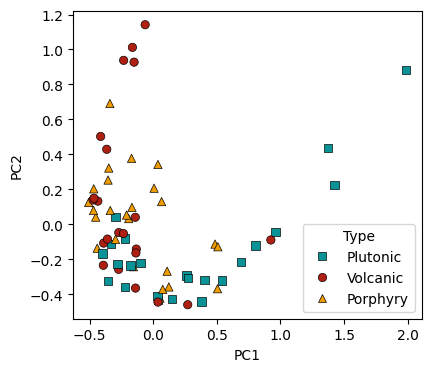

In [4]:
fig, axs = plt.subplots(1,1, figsize = (4.5,4))

colors = [(10/255, 147/255, 150/255),(174/255, 32/255, 18/255),(238/255, 155/255, 0/255)]
shapes = ['s','o','^']

pca_W2_data = geochron.generate_pca_scores()

sb.scatterplot(x=pca_W2_data['PC1'],y=pca_W2_data['PC2'],hue = pca_W2_data['Type'], style = pca_W2_data['Type'], markers = shapes,
              edgecolor = 'black', palette = colors, ax = axs, legend = True)

axs.set_xlabel('PC1')
axs.set_ylabel('PC2')

numValues = 1000
maxValue = 1
skewness = -10   #Negative values are left skewed, positive values are right skewed.

size_x = 0.27
size_y = 0.185

example_skews = [-100,0,100]

for skew in example_skews:
    x = stats.skewnorm.rvs(a = skew,loc=maxValue, size=numValues)  #Skewnorm function
    x = x - min(x)      #Shift the set so the minimum value is equal to zero.
    x = x / max(x)      #Standadize all the vlues between 0 and 1. 
    x = x * maxValue         #Multiply the standardized values by the maximum value.
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        pc1, pc2 = geochron.calc_W_PCA(x, np.ones(len(x)))
    
    ax = inset_axes(axs, "100%", "100%", 
                    bbox_to_anchor=(pc1-(size_x/2), pc2-(size_y/2), size_x, size_y),
                    bbox_transform=axs.transData, loc="center")
    
    sb.kdeplot(x, ax = ax)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_xlim([0,1])

x = np.linspace(0,1,10000)

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

legend = axs.legend(loc = 4, frameon = False)
plt.rcParams['svg.fonttype'] = 'none'
plt.show()

In [64]:
def bootstrap_sampling(age, n_zircon, n_simulations, distribution = 'MELTS', method = 'ID-TIMS', truncation = 1.0, n_inh = 0, dx = 1):

    """
    Bootstrap sampling of a zircon age distribution for a given age.

    Args:
        age (float): The age to sample at in Ma.
        n_zircon (int): The number of zircons to sample from the age distribution.
        n_simulations (int): The number of simulations of bootstap sampling to perform.
        distribution (string or int): The underlying age distribution to sample from (default = MELTS):
            - string options: MELTS, Triangular, Uniform, Volcanic Low Crystallinity, Volcanic, Half Normal, Reverse Triangular
            - int options: an integer between 0 and 20 to sample from the Magma Chamber Simulator outputs of Tavazzani et al. (2023)
        method (string): whether to sample for uncertainties relevant to ID-TIMS or LA-ICP-MS (default = ID-TIMS)
        truncation (float): value between 0 and 1 for truncating the age distribution, (default = 1 i.e. no truncation)
        n_inh (int): number of inherited/antecrystal zircons to add
        dx (float or list): distance in relative time the antecrystal population is from the main distribution, if a list is given should be (min, max)
        and a random value is drawn from this range

    Returns:
        np.array of an a
    """
    
    synthetic_distributions = np.zeros((n_simulations, n_zircon+n_inh))
    
    if distribution == 'MELTS':
        dist = pd.read_csv('../data/synthetic/MeltsTZircDistribution.tsv', header = None)[0]
    if distribution == 'Triangular':
        dist = pd.read_csv('../data/synthetic/TriangularDistribution.tsv', header = None)[0]
    if distribution == 'Uniform':
        dist = pd.read_csv('../data/synthetic/UniformDistribution.tsv', header = None)[0]
    if distribution == 'Volcanic Low Crystallinity':
        dist = pd.read_csv('../data/synthetic/VolcanicZirconLowXDistribution.tsv', header = None)[0]
    if distribution == 'Volcanic':
        dist = pd.read_csv('../data/synthetic/VolcanicZirconDistribution.tsv', header = None)[0]
    if distribution == 'Half Normal':
        dist = pd.read_csv('../data/synthetic/HalfNormalDistribution.tsv', header = None)[0]
    if distribution == 'Reverse Triangular':
        dist = pd.read_csv('../data/synthetic/ReverseTriangularDistribution.tsv', header = None)[0]
    if isinstance(distribution, int):
        mcs_distributions = pd.read_csv('../data/synthetic/Tavazzani2023MCS.csv', header = None)
        dist = mcs_distributions[distribution][::-1]
        dist = dist.dropna()

    dist = dist.iloc[:int(np.rint(len(dist)*truncation))]
    dist = dist.iloc[::-1]
    probabilities = dist/np.sum(dist)
    if method == 'ID-TIMS':
        sigma = geochron.TIMS_uncer(age)/2 # 1 sigma at the given age
    if method == 'LA-ICP-MS':
        sigma = geochron.laser_uncer(age)/2 # 1 sigma at the given age
    n = 0

    while n < n_simulations:
        synthetic = pd.Series(np.random.choice(np.linspace(start = 0, stop = 1.0, num = len(probabilities)), n_zircon, p=list(probabilities)))
        sigmas = np.random.normal(0, sigma, size=(len(synthetic),)) # Randomly generate analytical uncertainties 
        synthetic = synthetic + sigmas

        if n_inh != 0:
            if isinstance(dx, list):
                dxn = np.random.uniform(dx[0],dx[1], 1)
            else:
                dxn = dx

            
            synthetic_2 = pd.Series(np.random.choice(np.linspace(start = 0, stop = 1.0, num = len(probabilities))+dxn, n_inh, p=list(probabilities)))
            sigmas = np.random.normal(0, sigma, size=(len(synthetic_2),)) # Randomly generate analytical uncertainties 
            synthetic_2 = synthetic_2 + sigmas
            # New distribution 
            synthetic = pd.concat([synthetic,synthetic_2])
        
        synthetic = np.sort(geochron.normalize_age(synthetic))
        synthetic_distributions[n] = synthetic
        n = n + 1

    return synthetic_distributions



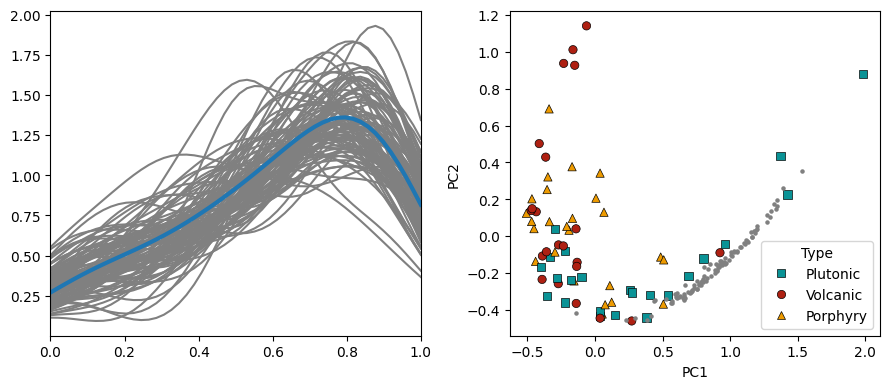

In [4]:
fig, axs = plt.subplots(1,2, figsize = (9, 4))

test = geochron.bootstrap_sampling(age = 1, n_zircon = 30, distribution = 'MELTS', n_simulations = 100, truncation = 1.0, 
                                   method = 'ID-TIMS', n_inh = 0, dx = 0)

for i in test:
    x, y = geochron.plot_kde(i, normalize = True)
    axs[0].plot(x,y, color = 'gray')

axs[0].set_xlim(0,1)
x, y = geochron.plot_kde(test.mean(axis=0), normalize = True)
sb.lineplot(x=x, y=y, linewidth = 3, ax = axs[0])


colors = [(10/255, 147/255, 150/255),(174/255, 32/255, 18/255),(238/255, 155/255, 0/255)]
shapes = ['s','o','^']

pca_W2_data = geochron.generate_pca_scores()

sb.scatterplot(x=pca_W2_data['PC1'],y=pca_W2_data['PC2'],hue = pca_W2_data['Type'], style = pca_W2_data['Type'], markers = shapes,
              edgecolor = 'black', palette = colors, legend = True, ax = axs[1])

synthetic_pca = np.zeros((len(test),2))
for n,i in enumerate(test):
    synthetic_pca[n] = geochron.calc_W_PCA(i, check = False)

axs[1].scatter(synthetic_pca[:,0], synthetic_pca[:,1], color = 'gray', s = 5)

plt.tight_layout()
plt.show()

In [63]:
isinstance([0,1], tuple)

False

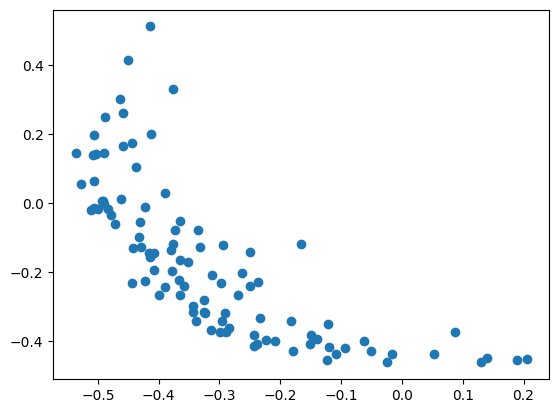

In [24]:
plt.scatter(synthetic_pca[:,0], synthetic_pca[:,1])

In [4]:
geochron.bootstrap_sampling()

TypeError: bootstrap_sampling() missing 3 required positional arguments: 'age', 'n_zircon', and 'n_simulations'

array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ])

In [107]:
probabilities

0    0.000027
1    0.022749
2    0.045470
3    0.068191
4    0.090926
5    0.113471
6    0.135158
7    0.155662
8    0.175172
9    0.193174
Name: 0, dtype: float64